In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm

datadir = "/home/ephy/Projects/tda_convolve_video/data/"

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'

from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

In [2]:
# f = open(datadir+"original/ucfTrainTestlist/trainlist01.txt", "r")
# temp = f.read()
# videos = temp.split('\n')

# # creating a dataframe having video names
# train = pd.DataFrame()
# train['video_name'] = videos
# train = train[:-1]

# # open the .txt file which have names of test videos
# f = open(datadir+"original/ucfTrainTestlist/testlist01.txt", "r")
# temp = f.read()
# videos = temp.split('\n')

# # creating a dataframe having video names
# test = pd.DataFrame()
# test['video_name'] = videos
# test = test[:-1]

In [3]:
# # creating tags
# train_video_tag = []
# for i in range(train.shape[0]):
#     train_video_tag.append(train['video_name'][i].split('/')[0])
    
# train['tag'] = train_video_tag

# test_video_tag = []
# for i in range(test.shape[0]):
#     test_video_tag.append(test['video_name'][i].split('/')[0])
    
# test['tag'] = test_video_tag

# allVids = train.append(test, ignore_index=True)

In [4]:
#Factor of 2.77 shrink getws us very close to 100^2 pixels, same as experiments before, but with aspect preserved
imageSize=np.array([np.round(320/2.77),np.round(240/2.77)],dtype=np.int)

In [5]:
# # storing the frames from training videos

# def one_run(i,allVids,datadir):
#     count = 0
#     videoFile = allVids['video_name'][i]
#     cap = cv2.VideoCapture(datadir + 'original/UCF/'+videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
#     frameRate = 1 #frame sample rate

#     frames = []
#     while(cap.isOpened()):
#         frameId = cap.get(1) #current frame number
#         ret, frame = cap.read()
#         if (ret != True):
#             break
#         if (frameId % math.floor(frameRate) == 0):
#             frames.append(frame)
#             count+=1
#     cap.release()
#     frames = np.stack(frames)
#     startPoints = np.array(range(0,frames.shape[0],9))[0:3]
#     clips = []
#     for start in startPoints:
#         clip = []
#         for f in range(start,start+9):
#             image = frames[f]
#             image = Image.fromarray(image , 'RGB')
#             image = image.resize(imageSize)
#             image = np.array(image)/255
#             image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#             clip.append(image)
#         clips.append(clip)

#     return(np.array(clips))
  

In [6]:
# all_images = Parallel(n_jobs=30)(delayed(one_run)(i,allVids,datadir) for i in tqdm(range(allVids.shape[0])))

In [7]:
# all_images = np.stack(all_images)

In [8]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/allVidStack100x100_FFR_9frames_3consecClips.npy', all_images)
all_image = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/allVidStack100x100_FFR_9frames_3consecClips.npy', allow_pickle=True)

In [9]:
allVids = pd.read_csv(datadir + 'altered/all_data_guide_FFR.csv')
allVids = allVids.sort_values(by=['clip', 'frame'])
allVids_dedup = allVids.drop_duplicates(subset=['clip'], keep='first').copy()

In [10]:
# Make an interger based class to make tracking tests more simple
classXwalk = pd.DataFrame({'class': np.unique(allVids_dedup['class'])})
classXwalk['ind'] = np.array(list(range(0,101)))
allVids_dedup['class_int'] = [int(classXwalk['ind'][classXwalk['class']==c]) for c in allVids_dedup['class']]

In [11]:
filters77 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_377_movAndRot180.npy', allow_pickle=True)

In [12]:
def test(net, X, y, batchSize):
    confusionMatrix = np.zeros([101,101], dtype=np.int8)
    testingSeq = list(range(0,y.shape[0]+1,batchSize))
    testingSeq.append(y.shape[0]+1)
    testingSeq = np.array(testingSeq)
    with torch.no_grad():
        for i in range(len(testingSeq)-1):
            data = X[testingSeq[i]:testingSeq[i+1]].view(-1,3,9,87,116).to(device)
            out = torch.argmax(net(data),axis=1).cpu()
            yt = torch.argmax(y[testingSeq[i]:testingSeq[i+1]],axis=1)
            for pred,label in zip(out,yt):
                confusionMatrix[label][pred] +=1
    del data
    del out
    del yt
    return confusionMatrix

In [13]:
class ResNet_lstm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 180, (3,7,7), bias=False)
        
        
        self.conv1 = nn.Conv3d(180, 180, (3,5,5))
        self.conv2 = nn.Conv3d(180, 180, (3,5,5))
        self.conv3 = nn.Conv3d(180, 180, (3,5,5))
        self.conv4 = nn.Conv3d(180, 180, (3,5,5))
        self.conv5 = nn.Conv3d(180, 180, (3,5,5))
        self.conv6 = nn.Conv3d(180, 180, (3,5,5))
        self.conv7 = nn.Conv3d(180, 75, (3,5,5))
        
        self.batchConv1 = nn.BatchNorm3d(180)
        self.batchConv2 = nn.BatchNorm3d(180)
        self.batchConv3 = nn.BatchNorm3d(180)
        self.batchConv4 = nn.BatchNorm3d(180)
        self.batchConv5 = nn.BatchNorm3d(75)
        
        self.up = nn.Upsample((7,27,36),mode='trilinear',align_corners=False)
        
        x= torch.randn(1,1,9,87,116)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 750)
        self.fc2 = nn.Linear(750, 200)
        self.fc3 = nn.Linear(200, 101)        
        
        self.batch1 = nn.BatchNorm1d(750)
        self.batch2 = nn.BatchNorm1d(200)
        self.drop2 = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(750,750)
        
        
    def convs(self, x):
        x = F.max_pool3d(self.convRescale(x),(1,3,3))
        x = self.batchConv1(x)
        inp1 = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchConv2(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchConv3(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.batchConv4(x)
        x = self.up(x)
        x+=inp1
        del inp1
        x = F.relu(self.conv7(x))
        x = self.batchConv5(x)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        hidden = [torch.randn(1, x.shape[0], 750).to(device),torch.randn(1, x.shape[0], 750).to(device)]
        out = torch.zeros(3,x.shape[0],750).to(device)
        for i in range(x.shape[1]):
            xi = x[:,i,...].view(x.shape[0],1,9,87,116)
            xi = self.convs(xi)
            xi = xi.view(-1, self._to_linear)
            xi = F.leaky_relu(self.fc1(xi))
            out[i,...] = xi
        del xi
        del x
        out, hidden = self.lstm(out,hidden)
        x = out[-1]
        del out
        del hidden
        x = self.batch1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.batch2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [14]:
net = ResNet_lstm().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)

# Set filters in 2 layers
with torch.no_grad():
    for i,weights in enumerate(filters77):
        net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.convRescale.requires_grad=False

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
#         plt.show()
#         break  

torch.cuda.memory_allocated()*1e-9

0.47843584000000006

In [15]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

foldIndex=0

# Set filters in 2 layers
# with torch.no_grad():
#     for i,weights in enumerate(filters77):
#         net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#     net.convRescale.requires_grad=False

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
#         plt.show()
#         break        
                



X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                    shuffle=True, random_state=foldIndex,
                                                    test_size=0.33, stratify = allVids_dedup['class_int'])


y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
trainingSeq.append(y_train.shape[0]+1)
trainingSeq = np.array(trainingSeq)

# # Grab 5 tests in final epoch (4 + last one run after training loop)
finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

for epoch in range(EPOCHS):
    for i in range(len(trainingSeq)-1):
        X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,3,9,87,116)
        X=X.to(device)
        y=y_train[trainingSeq[i]:trainingSeq[i+1]]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec[foldIndex].append(float(loss.tolist()))
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
#         if epoch==(EPOCHS-1) and (i in finalEpochTests):
#             print(foldIndex,'Final Epoch',i)
#             results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    print('Fold: ', foldIndex, 'Epoch: ',epoch)
    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    cm = results[foldIndex][len(results[foldIndex])-1]
    print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

RuntimeError: CUDA out of memory. Tried to allocate 380.00 MiB (GPU 0; 10.76 GiB total capacity; 7.63 GiB already allocated; 65.50 MiB free; 154.92 MiB cached)

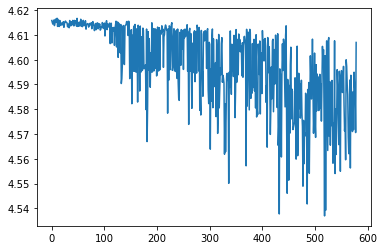

In [16]:
plt.plot(lossrec[0])

In [18]:
i=0
X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,3,9,87,116)
X=X.to(device)
y=y_train[trainingSeq[i]:trainingSeq[i+1]]
y=y.to(device)
net.zero_grad()
output = net(X)
# loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
# lossrec[foldIndex].append(float(loss.tolist()))
# loss.backward()
# optimizer.step()
# del loss
# del output
# del X
# del y



RuntimeError: CUDA out of memory. Tried to allocate 68.00 MiB (GPU 0; 10.76 GiB total capacity; 8.10 GiB already allocated; 68.56 MiB free; 82.09 MiB cached)

In [ ]:
# How to send tuple to GPU?

In [26]:
[torch.randn(1, 1, 3),torch.randn(1, 1, 3)]

[tensor([[[ 0.0554,  1.1340, -0.5326]]]),
 tensor([[[ 0.6592, -1.5964, -0.3769]]])]

In [30]:
torch.manual_seed(1)
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3

inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
# initialize the hidden state.
hidden = torch.randn(1,1,3)
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    print(i.shape)
    print(i.view(1, 1, -1).shape)
    print(hidden)
    out, h0, h1 = lstm(i.view(1, 1, -1), hidden)

# # alternatively, we can do the entire sequence all at once.
# # the first value returned by LSTM is all of the hidden states throughout
# # the sequence. the second is just the most recent hidden state
# # (compare the last slice of "out" with "hidden" below, they are the same)
# # The reason for this is that:
# # "out" will give you access to all hidden states in the sequence
# # "hidden" will allow you to continue the sequence and backpropagate,
# # by passing it as an argument  to the lstm at a later time
# # Add the extra 2nd dimension
# inputs = torch.cat(inputs).view(len(inputs), 1, -1)
# hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
# print(inputs)
# out, hidden = lstm(inputs, hidden)
# # print(out)
# # print(hidden)

torch.Size([1, 3])
torch.Size([1, 1, 3])
tensor([[[ 0.5438, -0.4057,  1.1341]]])


RuntimeError: Expected hidden[0] size (1, 1, 3), got (1, 3)